# Evaluación cuantitativa de algoritmos de cambio semánticos

In [1]:
# Importar librería
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pickle
import os
import re
import random as rn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import itertools

from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
tqdm.pandas()

In [2]:
# Configurar
load_dotenv() # Cargar las variables de entorno del archivo .env
BASE_DIR =  os.getenv("DIR_BASE")
RESULTADOS_DIR = os.getenv("DIR_DATOS_PROCESADOS") # Acceder a las variables de entorno
pd.set_option('display.max_colwidth', None)

In [3]:
umbral_top = 5
umbral_frec_menos = 5
umbral_frec_menos_full  = 9 
topn_vecinos = 100

# Config modelo https://radimrehurek.com/gensim/models/word2vec.html
tam_vector = 50 # Dimensionalidad de los vectores de palabras.
ventana = 10    # ventana ( int , opcional ): distancia máxima entre la palabra actual y la palabra prevista dentro de una oración.
min_frec = 2    # Ignora todas las palabras con una frecuencia total menor que esta.
w = 4   # utilice estos muchos subprocesos de trabajo para entrenar el modelo (=entrenamiento más rápido con máquinas de múltiples núcleos).
s = 1   # Algoritmo de entrenamiento: 1 para skip-gram; de lo contrario, CBOW.
e = 50  # Número de iteraciones (épocas) en el corpus. (Anteriormente: iter )
semilla = 1 # seed ( int , opcional ): Semilla para el generador de números aleatorios. 
iteracion = 10 

In [5]:
all_dfs = {}

df_names = [
    'procrustes', 
    'NN'
]

basenames = [
    'estabilidad_procrustes',
    'estabilidad_NN'
]

descriptions = [
    'Procrustes ortogonal',
    'k vecinos más cercanos'
]

flag = [
    True,
    False

]

In [6]:
# Unificamos archivos
for (i, (df_name, basename, description,f)) in enumerate(zip(df_names, basenames, descriptions,flag)):
    filename = RESULTADOS_DIR+'/archivos_out/'+basename+'_iter'+str(iteracion)+'_tam'+str(tam_vector)+'.csv'
    print('Leyendo', filename, end='...')
    df = pd.read_csv(filename)
    all_dfs[df_name] = {
        'df': df,
        'descripcion': description,
        'bandera': f
    }
    print('archivos:', df.shape)

Leyendo C:/Users/Usuario/iamas_iniciativasleg_salud/src/data//archivos_out/estabilidad_procrustes_iter10_tam50.csv...archivos: (10930, 7)
Leyendo C:/Users/Usuario/iamas_iniciativasleg_salud/src/data//archivos_out/estabilidad_NN_iter10_tam50.csv...archivos: (5090, 7)


In [7]:
# Normalizar nombres
all_dfs['procrustes']['df'].rename(
    columns={
        'top10_vecindad_t1': 'neighbors_t1', 
        'top10_vecindad_t2':'neighbors_t2'},
    inplace=True)
all_dfs['procrustes']['df'].head(1)

,iteracion,par_periodo,palabra,similaridad_semantica,cantidad_palabras_comun,neighbors_t1,neighbors_t2
0,3,"(2014, 2019)",accion,0.060316,460,"[('comunitario', 0.8162716031074524), ('familia', 0.6966067552566528), ('valor', 0.6862984895706177), ('mental', 0.6720057725906372), ('judicial', 0.6569758653640747), ('maternidad', 0.6415419578552246), ('enfermo', 0.6299411058425903), ('psicologico', 0.6294134855270386), ('listado', 0.6239563226699829), ('julio', 0.6164337992668152)]","[('celula', 0.8134423494338989), ('organo', 0.7656179070472717), ('epidemiologico', 0.7550835013389587), ('recoleccion', 0.7297802567481995), ('proteina', 0.6986029744148254), ('promover', 0.6904392838478088), ('alergia', 0.6731252670288086), ('aplv', 0.6659174561500549), ('donacion', 0.6445348262786865), ('artriti', 0.6362723708152771)]"


In [9]:
#print(all_dfs['procrustes']['df']['par_periodo'].unique())

In [10]:
# Normalizar
all_dfs['NN']['df'].rename(
    columns={
        'topn_vecindad_t1': 'neighbors_t1', 
        'topn_vecindad_t2': 'neighbors_t2'},
    inplace=True)
all_dfs['NN']['df'].head(1)

,iteracion,par_periodo,palabra,similaridad_semantica,cantidad_palabras_comun,neighbors_t1,neighbors_t2
0,1,"(2009, 2014)",tipo,0,0,"['territorio', 'vacunacion', 'sanitario', 'enfermedad', 'gratuito', 'tecnica', 'mujer', 'humano', 'obligatorio', 'declarar', 'emergencia', 'edad', 'zona', 'incorporacion', 'anos']","['practica', 'distribucion', 'tabaco', 'consumo', 'comercializacion', 'medico']"


In [11]:
#print(all_dfs['NN']['df']['par_periodo'].unique())

Aplicamos la comparación a la tarea de detección de cambios en el uso de palabras primero para los pareas 2009-2013 y 2014-2018 y luego, para 2014-2018 y 2019-2023. 

Utilizamos la intersección @k, propuesta por Gonen et al., que mide el porcentaje de palabras compartidas en las k palabras más cambiadas durante varios reinicios, cambiando cada vez la semilla aleatoria.

 Para cada enfoque (p. ej., procrustes) y entre los dos períodos, medimos el cambio en el uso de palabras y detectamos las palabras más cambiadas. Al repetir la medición con diferentes semillas aleatorias, calculamos las palabras comunes cambiadas en las repeticiones. Específicamente, ejecutamos cada enfoque de cambio de uso 12 veces y recopilamos las k palabras más cambiadas, donde k ∈ [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000]
. Luego, para cada uno de los (15 2 )= Combinaciones de 15 elementos tomados de 2 en 2 = 105  pares de ejecuciones diferentes y para cada uno de los valores de k, medimos el porcentaje de palabras compartidas en las predicciones de palabras con mayor cambio de cada enfoque. Un valor de cero entre un par de ejecuciones significa que no hay palabras compartidas en sus predicciones, lo que indica alta variabilidad, mientras que un valor de uno indica alta estabilidad.

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
procrustes
NN


c:\Users\Usuario\iamas_iniciativasleg_salud\myenv_IL\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_37444\3870194675.py:45: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((intersection_per_pair,), np.mean, confidence_level=0.95)


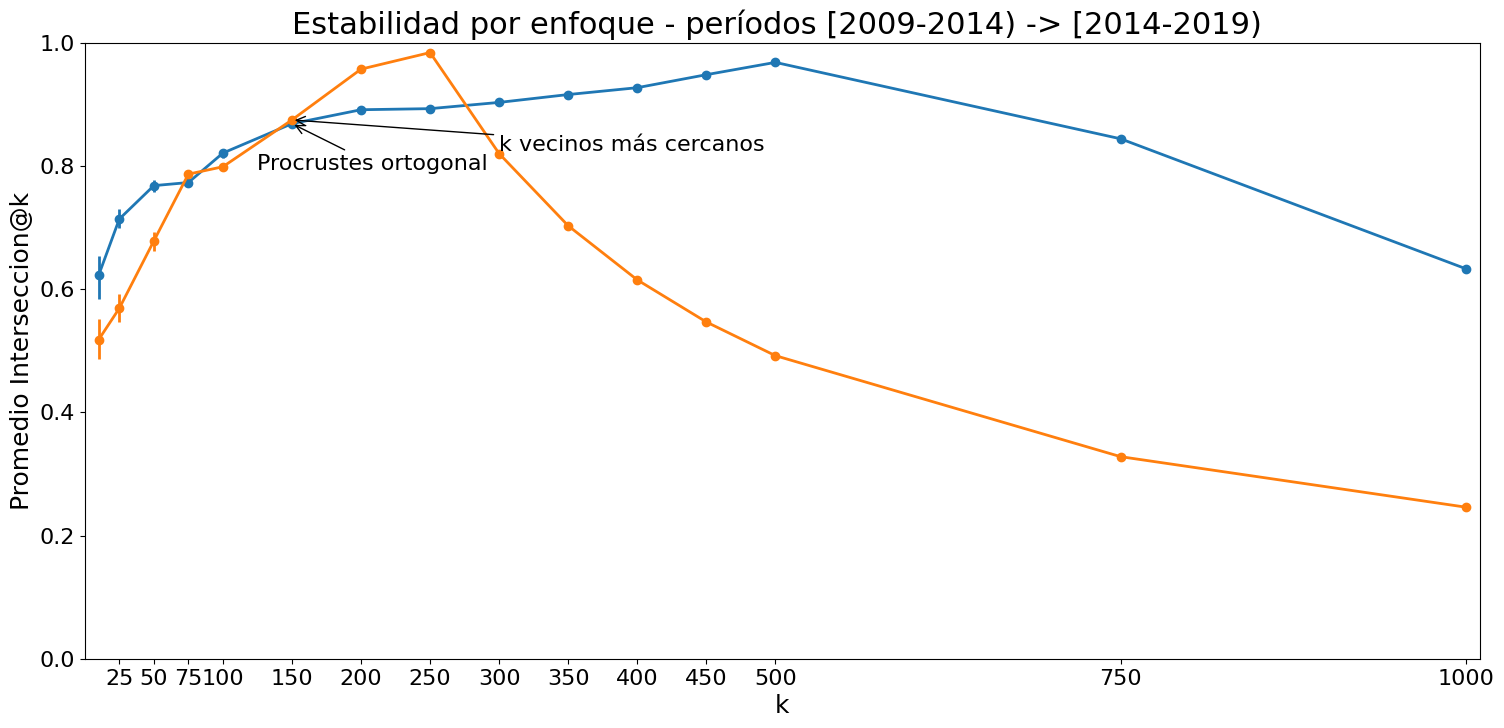

In [12]:
fig = plt.figure(figsize=(18, 8))

k = [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000]

all_pairs = list(itertools.combinations(range(iteracion), 2))
print(all_pairs)

xy_indx = {
    'procrustes': 5, 
    'NN': 5, 
}

xytext_offsets = {
    'NN': (150, -0.05), 
    'procrustes': (-25, -0.075),

}

for method_name, method_results in all_dfs.items(): 
    print(method_name)
    label = method_results['descripcion']
    df = method_results['df']
    df = df[df['par_periodo']=='(2009, 2014)']
    flag = method_results['bandera']
    X = []
    Y = []
    yerr = [
        [], # lower errors
        [] # upper errors
    ]
    
    for n in k:
        intersection_per_pair = np.zeros(len(all_pairs))

        for i, pair in enumerate(all_pairs):

            iteration_0_topk = df.loc[(df.iteracion==pair[0])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            iteration_1_topk = df.loc[(df.iteracion==pair[1])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            intersection = len(set(iteration_0_topk).intersection(set(iteration_1_topk)))
            intersection_per_pair[i] = intersection / n

        intersection_at_k = np.mean(intersection_per_pair)
        Y.append(intersection_at_k)
        X.append(n)
        res = bootstrap((intersection_per_pair,), np.mean, confidence_level=0.95)
        yerr[0].append(intersection_at_k - res.confidence_interval.low)
        yerr[1].append(res.confidence_interval.high - intersection_at_k)

    plt.errorbar(X, Y, yerr=yerr, label=label, linewidth=2, fmt='-o')# alpha=0.7, 
                 #fmt='-o', solid_capstyle='projecting', capsize=5)
    plt.annotate(label, 
                 xy=(X[xy_indx[method_name]], Y[xy_indx[method_name]]), 
                 xytext=(X[xy_indx[method_name]] + xytext_offsets[method_name][0], 
                         Y[xy_indx[method_name]] + xytext_offsets[method_name][1]),
                 fontsize=16,
                 arrowprops=dict(arrowstyle='->'))
    
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0, 1)
plt.xlim(0, 1010)
plt.xticks(k[1:])
plt.xlabel('k', fontsize=18)
plt.ylabel('Promedio Ιnterseccion@k', fontsize=18)
plt.title('Estabilidad por enfoque - períodos [2009-2014) -> [2014-2019) ', fontsize=22)

plt.savefig(RESULTADOS_DIR+'/archivos_out/comparacion_estabilidad_error_bars_2009_2014.png', dpi=300,  bbox_inches='tight')

procrustes


C:\Users\Usuario\AppData\Local\Temp\ipykernel_37444\2525468848.py:45: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((intersection_per_pair,), np.mean, confidence_level=0.95)


NN


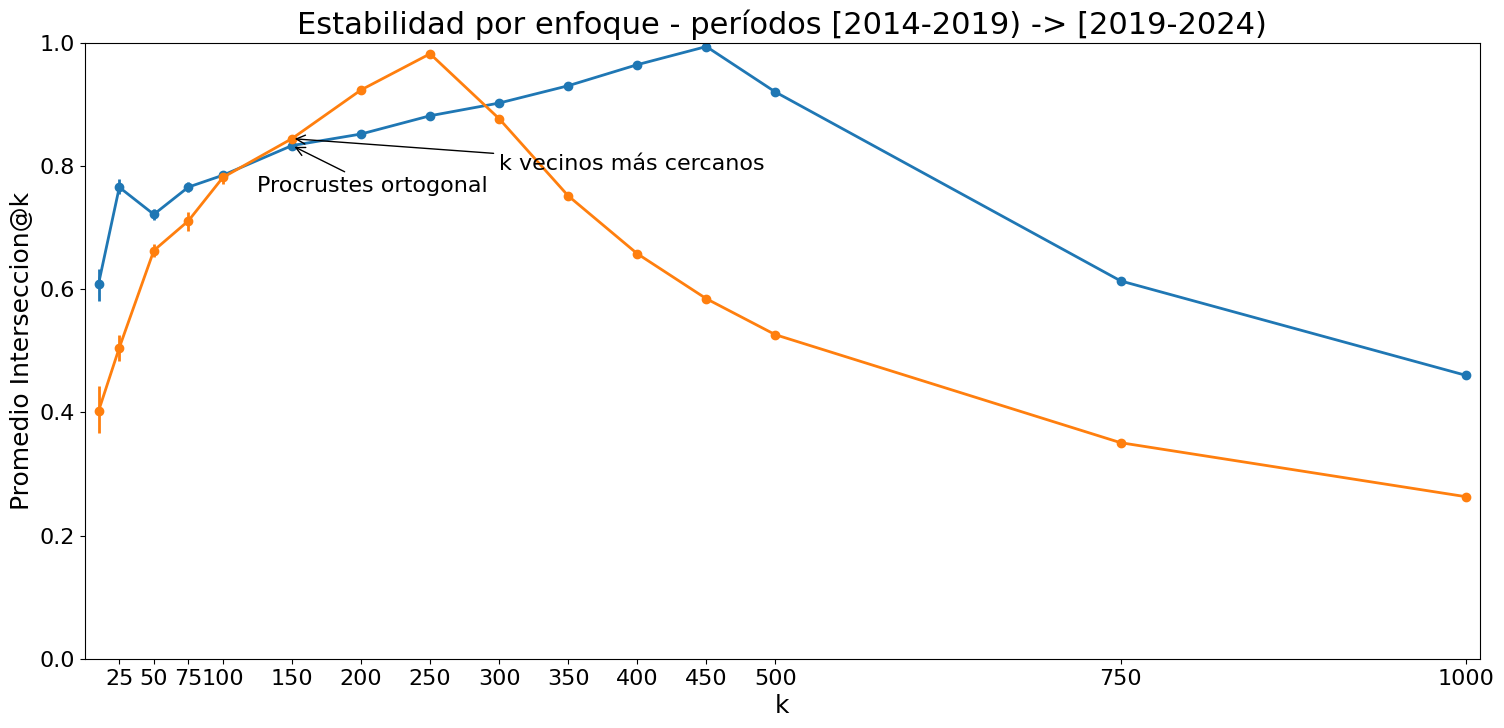

In [13]:
fig = plt.figure(figsize=(18, 8))

k = [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000]


all_pairs = list(itertools.combinations(range(iteracion), 2))

xy_indx = {
    'procrustes': 5, 
    'NN': 5, 
}

xytext_offsets = {
    'NN': (150, -0.05), 
    'procrustes': (-25, -0.075),

}


for method_name, method_results in all_dfs.items(): 
    print(method_name)
    label = method_results['descripcion']
    df = method_results['df']
    df = df[df['par_periodo']=='(2014, 2019)']
    flag = method_results['bandera']
    X = []
    Y = []
    yerr = [
        [], # lower errors
        [] # upper errors
    ]
    
    for n in k:
        intersection_per_pair = np.zeros(len(all_pairs))

        for i, pair in enumerate(all_pairs):
            iteration_0_topk = df.loc[(df.iteracion==pair[0])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            iteration_1_topk = df.loc[(df.iteracion==pair[1])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            intersection = len(set(iteration_0_topk).intersection(set(iteration_1_topk)))
            intersection_per_pair[i] = intersection / n

        intersection_at_k = np.mean(intersection_per_pair)
        Y.append(intersection_at_k)
        X.append(n)
        res = bootstrap((intersection_per_pair,), np.mean, confidence_level=0.95)
        yerr[0].append(intersection_at_k - res.confidence_interval.low)
        yerr[1].append(res.confidence_interval.high - intersection_at_k)

    plt.errorbar(X, Y, yerr=yerr, label=label, linewidth=2, fmt='-o')# alpha=0.7, 
                 #fmt='-o', solid_capstyle='projecting', capsize=5)
    plt.annotate(label, 
                 xy=(X[xy_indx[method_name]], Y[xy_indx[method_name]]), 
                 xytext=(X[xy_indx[method_name]] + xytext_offsets[method_name][0], 
                         Y[xy_indx[method_name]] + xytext_offsets[method_name][1]),
                 fontsize=16,
                 arrowprops=dict(arrowstyle='->'))
    
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0, 1)
plt.xlim(0, 1010)
plt.xticks(k[1:])
plt.xlabel('k', fontsize=18)
plt.ylabel('Promedio Ιnterseccion@k', fontsize=18)
plt.title('Estabilidad por enfoque - períodos [2014-2019) -> [2019-2024)', fontsize=22)

plt.savefig(RESULTADOS_DIR+'/archivos_out/comparacion_estabilidad_error_bars_2014_2019.png', dpi=300,  bbox_inches='tight')

procrustes
NN


Text(0.5, 1.0, 'Estabilidad por enfoque')

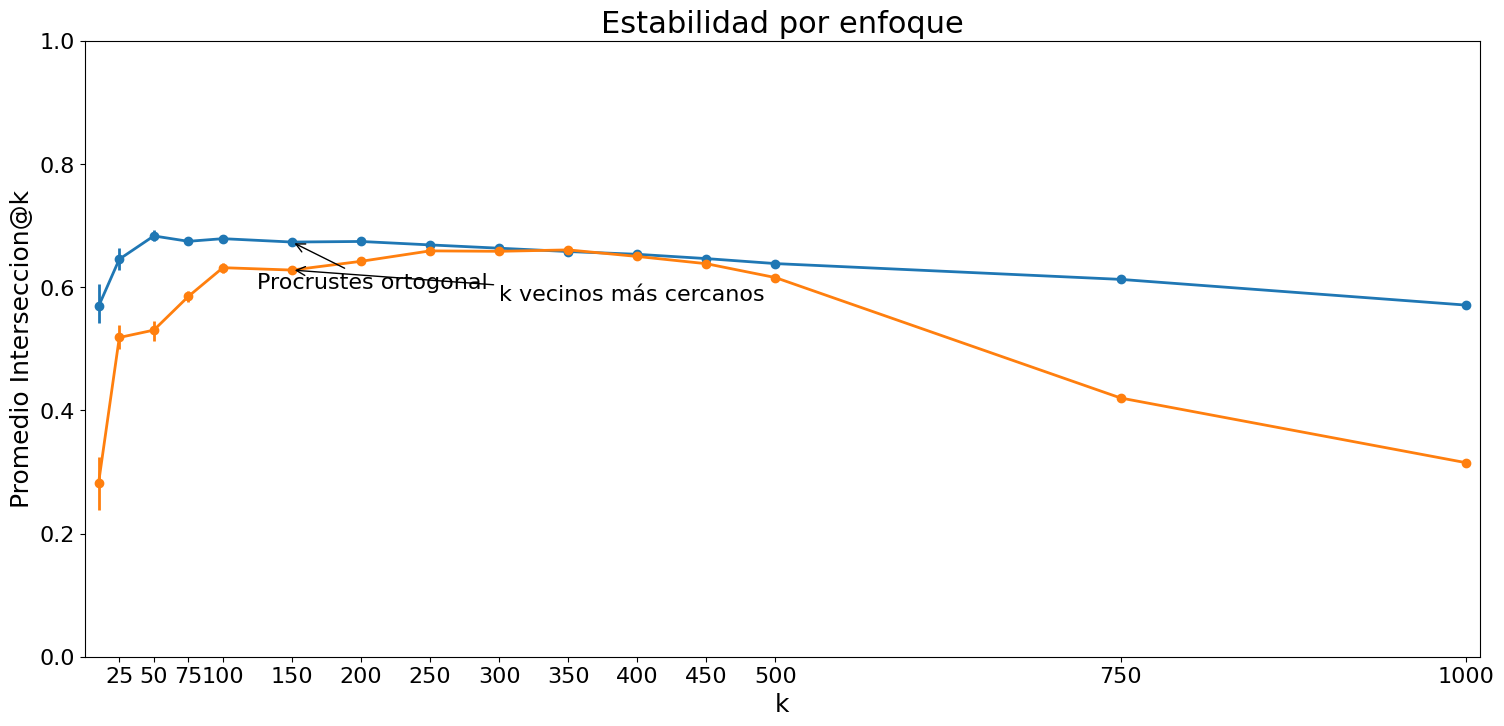

In [14]:
fig = plt.figure(figsize=(18, 8))

k = [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000]


all_pairs = list(itertools.combinations(range(iteracion), 2))

xy_indx = {
    'procrustes': 5, 
    'NN': 5, 
}

xytext_offsets = {
    'NN': (150, -0.05), 
    'procrustes': (-25, -0.075),

}


for method_name, method_results in all_dfs.items(): 
    print(method_name)
    label = method_results['descripcion']
    df = method_results['df']
    flag = method_results['bandera']
   
    X = []
    Y = []
    yerr = [
        [], # lower errors
        [] # upper errors
    ]
    
    for n in k:
        intersection_per_pair = np.zeros(len(all_pairs))

        for i, pair in enumerate(all_pairs):
            iteration_0_topk = df.loc[(df.iteracion==pair[0])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            iteration_1_topk = df.loc[(df.iteracion==pair[1])].sort_values('similaridad_semantica', ascending=flag)['palabra'][:n]
            intersection = len(set(iteration_0_topk).intersection(set(iteration_1_topk)))
            intersection_per_pair[i] = intersection / n

        intersection_at_k = np.mean(intersection_per_pair)
        Y.append(intersection_at_k)
        X.append(n)
        res = bootstrap((intersection_per_pair,), np.mean, confidence_level=0.95)
        yerr[0].append(intersection_at_k - res.confidence_interval.low)
        yerr[1].append(res.confidence_interval.high - intersection_at_k)

    plt.errorbar(X, Y, yerr=yerr, label=label, linewidth=2, fmt='-o')# alpha=0.7, 
                 #fmt='-o', solid_capstyle='projecting', capsize=5)
    plt.annotate(label, 
                 xy=(X[xy_indx[method_name]], Y[xy_indx[method_name]]), 
                 xytext=(X[xy_indx[method_name]] + xytext_offsets[method_name][0], 
                         Y[xy_indx[method_name]] + xytext_offsets[method_name][1]),
                 fontsize=16,
                 arrowprops=dict(arrowstyle='->'))
    
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0, 1)
plt.xlim(0, 1010)
plt.xticks(k[1:])
plt.xlabel('k', fontsize=18)
plt.ylabel('Promedio Ιnterseccion@k', fontsize=18)
plt.title('Estabilidad por enfoque', fontsize=22)


Las figuras para cada periodo, como está última, muestra la intersección promedio @k entre los 105 pares de ejecuciones diferentes para cada enfoque y periodo, con intervalos de confianza del 95 % calculados mediante el método bootstrap. 

No se observa estabilidad en general. El método procruste presenta un poco más de estabilidad que NN. Esto significa que, los valores de k entre [100 a 500] independientemente de la semilla aleatoria utilizada, las palabras modificadas que detectó este enfoque fueron más cercanas aunque no practicamente las mismas. Para K > 500 la estabilidad decrece entre los enfoques comparados.

Se tomará **k= 150** para evaluar cualitativamente los enfoques y los períodos, al ser el valor de intesección entre enfoques y tener un 80% de palabras compartidas en las predicciones de palabras con mayor cambio de cada enfoque.


### Palabras más cambiadas por período de 5 años

In [15]:
#print(all_dfs['NN']['df']['par_periodo'].unique())
#print(all_dfs['procrustes']['df']['par_periodo'].unique())
pares_periodo = [ (2009, 2014),(2014, 2019)]
pares_periodo

[(2009, 2014), (2014, 2019)]

In [18]:
''' para verificar
# Frecuencia de palabras por período
df = all_dfs['NN']['df']
par_periodo = (2009, 2014)
df = df[df['par_periodo'] == str(par_periodo)]
flag = all_dfs['NN']['bandera']
frecPer1 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[0])+'.csv')
frecPer2 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[1])+'.csv')
frecPer1.columns = ['palabra', 'frec1', 'porc1']
frecPer2.columns = ['palabra', 'frec2', 'porc2']
df = df[df['par_periodo'] == str(par_periodo)]
df.head(2)
'''

" para verificar\n# Frecuencia de palabras por período\ndf = all_dfs['NN']['df']\npar_periodo = (2009, 2014)\ndf = df[df['par_periodo'] == str(par_periodo)]\nflag = all_dfs['NN']['bandera']\nfrecPer1 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[0])+'.csv')\nfrecPer2 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[1])+'.csv')\nfrecPer1.columns = ['palabra', 'frec1', 'porc1']\nfrecPer2.columns = ['palabra', 'frec2', 'porc2']\ndf = df[df['par_periodo'] == str(par_periodo)]\ndf.head(2)\n"

### Evaluación cualitativa: Palabras con mayor cambio entre pares [2009-2014) y [2014-2019) y [2014-2019) a  [2019-2024)

Evaluamos cualitativamente las 150 palabras con mayor cambio entre los pares de períodos, según cada enfoque. Introducimos un umbral de frecuencia de 9 ocurrencias en al menos uno de los períodos de 5 años para los enfoques que aún no cuentan con umbrales de frecuencia.

* Cuartil 75% de Frecuencia = 8.5 

Muestra una selección representativa de resultados para cada enfoque evaluando una iteración.

In [19]:
n = 150
at_least_in_any_decade = 9


csvs = []
topn_periodo_dic = {}
for par_periodo in pares_periodo:
    
    enfoque_topn = {} 
    for method_name, method_results in all_dfs.items(): 

        print(method_name)
        label = method_results['descripcion']
        df = method_results['df']
        df = df[df['par_periodo']== str(par_periodo)]
        flag = method_results['bandera']

        #print(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[0])+'.csv')
        frecPer1 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[0])+'.csv')
        frecPer2 = pd.read_csv(RESULTADOS_DIR+'/archivos_out/frec_para_datos_limpios_por_desplaz_semantico_anios5_'+str(par_periodo[1])+'.csv')
        frecPer1.columns = ['palabra', 'frec1', 'porc1']
        frecPer2.columns = ['palabra', 'frec2', 'porc2']
        
        df_topn = df.loc[(df.iteracion==0)]
        #controlar frec
        df_topn = df_topn.merge(frecPer1, how='left', on='palabra')
        df_topn = df_topn.merge(frecPer2, how='left', on='palabra')

        
        df_topn['max_freq_of_any_decade'] = df_topn[['frec1', 'frec2']].max(axis=1)
        df_topn.drop(['frec1', 'frec2', 'porc1', 'porc2'], axis=1, inplace=True) 
        df_topn = df_topn.loc[df_topn.max_freq_of_any_decade>= at_least_in_any_decade].head(n)
        df_topn = df_topn[['palabra','similaridad_semantica','neighbors_t1', 'neighbors_t2']].sort_values('similaridad_semantica', ascending=flag).head(n)
        enfoque_topn[method_name] = df_topn
        
        new_name = method_name.lower().replace(' ', '_')
        new_name = new_name.replace('-', '')
        new_periodo = str(par_periodo)
        new_periodo = new_periodo.replace('(', '')
        new_periodo = new_periodo.replace(')', '')
        new_periodo = new_periodo.replace(',', '_')
        
        csv_path = RESULTADOS_DIR+'/archivos_out/'+new_name+'_periodo'+str(new_periodo)+'_top'+str(n)+'.csv'
        #csvs.append(csv_path)

        df_topn.to_csv(csv_path, index=False)
        csvs.append(df_topn)

    topn_periodo_dic[par_periodo] = enfoque_topn

procrustes
NN
procrustes
NN


In [20]:
K= 10
for enfoque, dicTop in topn_periodo_dic.items():
    print(enfoque)
    print("Procrustes: ",[pal[0] for pal in dicTop['procrustes'][['palabra']].head(K).values])
    print("NN:",[pal[0] for pal in dicTop['NN'][['palabra']].head(K).values])
    

(2009, 2014)
Procrustes:  ['tipo', 'riesgo', 'educacion', 'alto', 'poblacion', 'personal', 'territorio', 'respectivamente', 'dengue', 'marco']
NN: ['tipo', 'trastorno', 'minimo', 'dengue', 'territorio', 'complementario', 'discapacidad', 'poblacion', 'educacion', 'campana']
(2014, 2019)
Procrustes:  ['poblacion', 'necesario', 'derivado', 'pais', 'marco', 'gluten', 'general', 'evaluacion', 'sustancia', 'afectado']
NN: ['cuidado', 'sexual', 'condicion', 'sustancia', 'decreto', 'identificacion', 'sanitario', 'ambito', 'victima', 'evaluacion']


Los modelos por periodo en base a embeding entrenados en menos de 2000 títulos por período presentan inestabilidad, como se observo en las gráficas anteriores. 
A nivel cualitativo el enfoque Procrustes detecta más verbos,  adjentivos (alto, minimo, complementario, general ) y adverbio (respectivamente) que NN.
El enfoque NN evidencia de manera más directas palabras que uno asociaría al covid 19 (sanitario, decreto, victima) y a temas vinculado con la sexualidad (sexual).

Tanto Procruste y NN  identifican cambios semanticos de determinadas palabras entre el par de períodos:
* [2009, 2014) y [2014, 2019): tipo, educacion, poblacion, territorio y dengue .
* [2014, 2019) y [2019, 2024): sustancia y evaluación.


Los modelos generados en general son inestables al ser entrenados en pocos datos. Pero aún así
* Si buscamos estabilidad y comparabilidad: Orthogonal Procrustes sería la opción.
* Si buscamos una detección simple y efectiva : NN (Nearest Neighbors) es fácil de aplicar.